In [39]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import log_loss

# Fisher information / Natural gradients

In [53]:
Nsamples = 100
dataAclass0 = np.random.multivariate_normal(np.array([1, 1]),
                                            np.eye(2), Nsamples//2)
dataAclass1 = np.random.multivariate_normal(np.array([1, 2]), 
                                            np.eye(2), Nsamples//2)
dataA = np.vstack((dataAclass0, dataAclass1))
dataBclass0 = np.copy(dataAclass0)
dataBclass0[:, 0] = dataAclass0[:, 0] + 5
dataBclass1 = np.copy(dataAclass1)
dataBclass1[:, 0] = dataAclass1[:, 0] + 5
dataB = np.vstack((dataBclass0, dataBclass1))
correct_labels = [0] * 50 + [1] * 50

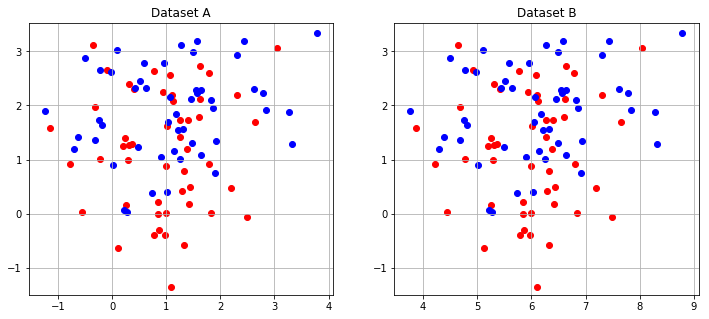

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(dataAclass0[:, 0], dataAclass0[:, 1], color='red')
ax[0].scatter(dataAclass1[:, 0], dataAclass1[:, 1], color='blue')
ax[0].grid(True)
ax[0].axis('equal')
ax[0].set_title('Dataset A')
ax[1].scatter(dataBclass0[:, 0], dataBclass0[:, 1], color='red')
ax[1].scatter(dataBclass1[:, 0], dataBclass1[:, 1], color='blue')
ax[1].grid(True)
ax[1].axis('equal')
ax[1].set_title('Dataset B')
plt.show()

## Forward pass

In [43]:
def z(phi, r, x):
    return 1 / (1 + np.exp(
        -np.sin(phi) * x[:, 0] - np.cos(phi) * x[:, 1] - r
    ))

In [56]:
N = 50
M = 50
phispace = np.linspace(0, 2 * np.pi, N)
rspace = np.linspace(-5, 5, M)

In [59]:
heatA = np.zeros((M, N))
heatB = np.zeros((M, N))
for i, phi in enumerate(phispace):
    for j, r in enumerate(rspace):
        heatA[i, j] = log_loss(correct_labels, z(phi, r, dataA))
        heatB[i, j] = log_loss(correct_labels, z(phi, r, dataB))

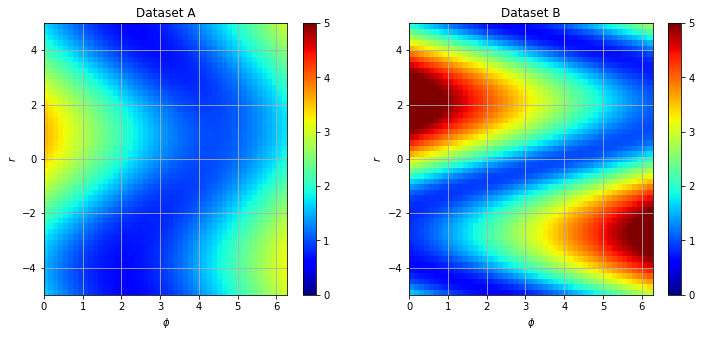

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pcm = ax[0].pcolor(phispace, rspace, heatA, cmap='jet', vmin=0, vmax=5)
ax[0].grid(True)
ax[0].set_xlabel('$\phi$')
ax[0].set_ylabel('$r$')
ax[0].set_title('Dataset A')
fig.colorbar(pcm, ax=ax[0])
pcm = ax[1].pcolor(phispace, rspace, heatB, cmap='jet', vmin=0, vmax=5)
ax[1].grid(True)
ax[1].set_xlabel('$\phi$')
ax[1].set_ylabel('$r$')
ax[1].set_title('Dataset B')
fig.colorbar(pcm, ax=ax[1])
plt.show()

Observation: Works way better for dataset A in general. Also, the choice of $\phi$ and R is much more relevant to achieve a good result on B.

## Fisher matrix

In [83]:
def make_fisher(phi, r, x):
    mat = np.zeros((2, 2))  # [[F_phiphi, F_phir], [F_phir, F_rr]]
    term_dphi_y0 = (
        (np.cos(phi) * x[:, 0] - np.sin(phi) * x[:, 1]) 
        / (1 + np.exp(np.sin(phi) * x[:, 0] - np.cos(phi) * x[:, 1] + r))
    )
    term_dphi_y1 = (
        (np.cos(phi) * x[:, 0] - np.sin(phi) * x[:, 1]) 
        / (1 + np.exp(np.sin(phi) * x[:, 0] - np.cos(phi) * x[:, 1] + r))
        - np.cos(phi) * x[:, 0]
        + np.sin(phi) * x[:, 1]
    )
    term_dr_y0 = 1 / (1 + np.exp(
        np.sin(phi) * x[:, 0] + np.cos(phi) * x[:, 1] + r
    ))
    term_dr_y1 = 1 / (1 + np.exp(
        np.sin(phi) * x[:, 0] + np.cos(phi) * x[:, 1] + r
    )) - 1
    mat[0, 0] = np.sum(
        term_dphi_y0 * term_dphi_y0 * z(phi, r, x)
        + term_dphi_y1 * term_dphi_y1 * z(phi, r, x)
    )
    mat[1, 0] = np.sum(
        term_dphi_y0 * term_dr_y0 * z(phi, r, x)
        + term_dphi_y1 * term_dr_y1 * z(phi, r, x)
    )
    mat[1, 1] = np.sum(
        term_dr_y0 * term_dr_y0 * z(phi, r, x)
        + term_dr_y1 * term_dr_y1 * z(phi, r, x)
    )
    
    mat[0, 1] = mat[1, 0]
    return mat

fisherA = np.zeros((M, N, 2, 2))
fisherB = np.zeros((M, N, 2, 2))
for i, phi in enumerate(phispace):
    for j, r in enumerate(rspace):
        fisherA[i, j, :, :] = make_fisher(phi, r, dataA)
        fisherB[i, j, :, :] = make_fisher(phi, r, dataB)

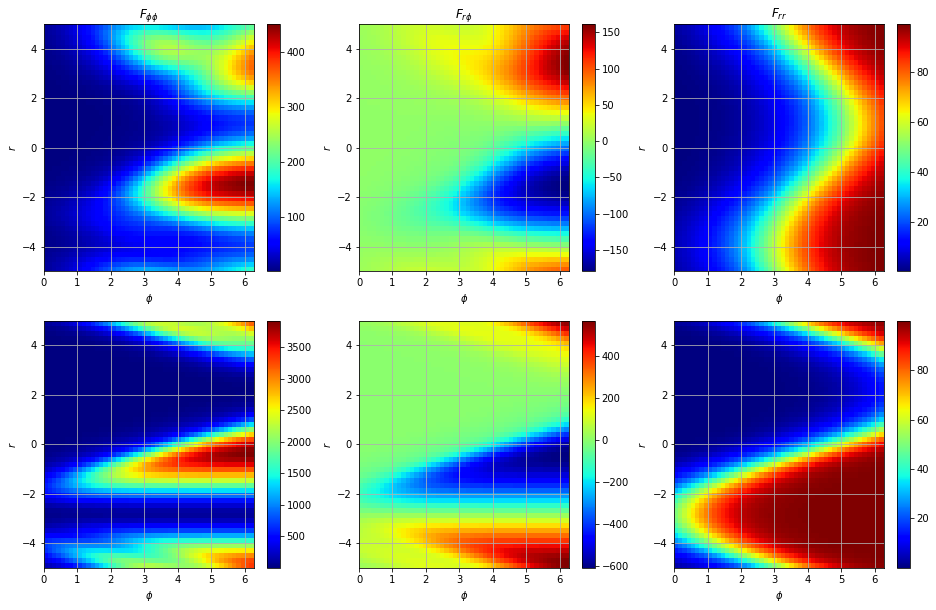

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for i, fisher in enumerate([fisherA, fisherB]):
    pcm = ax[i, 0].pcolor(phispace, rspace, fisher[:, :, 0, 0], cmap='jet')
    ax[i, 0].grid(True)
    ax[i, 0].set_xlabel('$\phi$')
    ax[i, 0].set_ylabel('$r$')
    fig.colorbar(pcm, ax=ax[i, 0])
    pcm = ax[i, 1].pcolor(phispace, rspace, fisher[:, :, 1, 0], cmap='jet')
    ax[i, 1].grid(True)
    ax[i, 1].set_xlabel('$\phi$')
    ax[i, 1].set_ylabel('$r$')
    fig.colorbar(pcm, ax=ax[i, 1])
    pcm = ax[i, 2].pcolor(phispace, rspace, fisher[:, :, 1, 1], cmap='jet')
    ax[i, 2].grid(True)
    ax[i, 2].set_xlabel('$\phi$')
    ax[i, 2].set_ylabel('$r$')
    fig.colorbar(pcm, ax=ax[i, 2])
ax[0, 0].set_title(r'$F_{\phi\phi}$')
ax[0, 1].set_title(r'$F_{r\phi}$')
ax[0, 2].set_title(r'$F_{rr}$')
plt.show()